# Trénovanie modelu iba na základe DST indexu 3 h dozadu, predikcia súčasnej hodnoty
Súbor: 3_dozadu.ipynb

Program: Hospodárska informatika

Vypracovala: Bc. Veronika Motúzová

Diplomová práca: : Predikcia geomagnetickych búrok pomocou hlbokého učenia

Vedúci diplomovej práce: doc. Ing. Peter Butka, PhD.

Konzultanti: Ing. Viera Maslej Krešňáková, PhD., RNDr. Šimon Mackovjak, PhD. 

### Inštalácia knižníc

In [ ]:
!pip install pyarrow
!pip install keras
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-gpu

### Kontrola kapacity servera

In [1]:
!nvidia-smi

Mon Feb 27 11:44:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K40c          Off  | 00000000:01:00.0 Off |                    0 |
| 24%   46C    P0    71W / 235W |      0MiB / 11441MiB |     69%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import knižníc

In [2]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential

from keras.layers import Dense, Activation, Dropout, Input, Conv1D, LSTM, MaxPooling1D, Flatten, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model


from scipy.special import expit, logit

from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef

### Načitanie dát, odstránenie na hodnôt, určenie predikovaného atribútu

In [3]:
train = pd.read_csv('train_omni.csv')
test = pd.read_csv('test_omni.csv')
features = ['time1',
            'DST']
test = test[features]
train = train[features]
train['time1']=pd.to_datetime(train['time1'])
test['time1']=pd.to_datetime(test['time1'])
predicted_label = 'DST'

y_col='DST'
valid_size = int(len(train) * 0.2)
valid = train.iloc[-valid_size:,:].copy()
train = train.iloc[:-valid_size,:].copy()

y_train = train[y_col].values.copy()
X_train = train[y_col].values.copy()
y_val = valid[y_col].values.copy()
X_val = valid[y_col].values.copy()
y_test = test[y_col].values.copy()
X_test = test[y_col].values.copy()

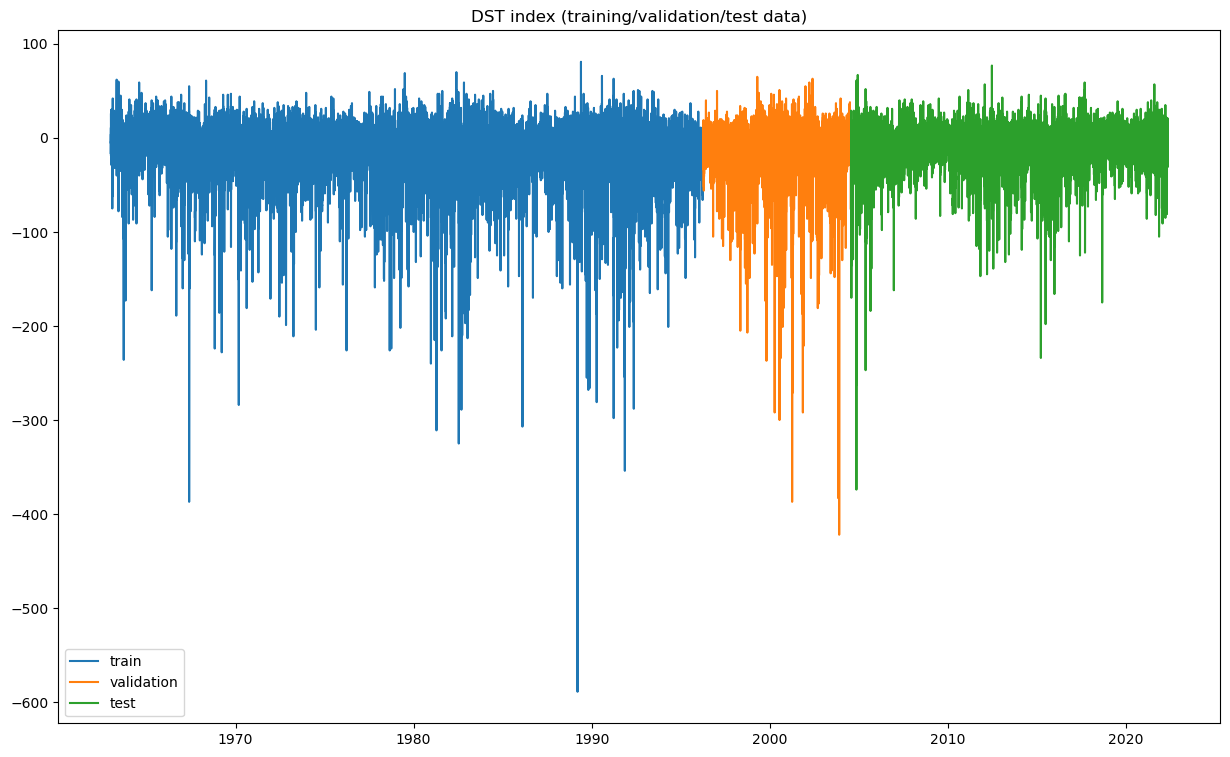

In [4]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
%matplotlib inline
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [15, 9]
plt.figure()
plt.title("DST index (training/validation/test data)")
plt.plot(train['time1'],train['DST'],label='train')
plt.plot(valid['time1'],valid['DST'],label='validation')
plt.plot(test['time1'],test['DST'],label='test')
plt.legend();

In [5]:
# set batch, n_input, n_features

n_input = 3  # how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= len(X_train)  # how many predictors/Xs/features we have to predict y
b_size = 256  # Number of timeseries samples in each batch

train_generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=b_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=n_input, batch_size=b_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=n_input, batch_size=256)

In [6]:
print("Počet batchov: ", len(train_generator))
print("Každý batch má features (X zložku) a labels (y zložku): ", len(train_generator[0]))
print("Dĺžka X zložky batchu: ", len(train_generator[0][0]))
print("Dĺžka y zložky batchu (počet meraní v batchi): ",len(train_generator[0][1]))
print("Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu): ", len(train_generator[0][0][0]))

Počet batchov:  1139
Každý batch má features (X zložku) a labels (y zložku):  2
Dĺžka X zložky batchu:  256
Dĺžka y zložky batchu (počet meraní v batchi):  256
Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu):  3


In [7]:
inputs = Input(shape=(n_input,1))
c = Bidirectional(LSTM(128, return_sequences=True, dropout=0.1,recurrent_dropout=0.1))(inputs)
c = LSTM(128, return_sequences=True)(c)
c = TimeDistributed(Dense(1, activation='linear'))(c)
output = Flatten()(c)
output = Dense(1, activation='linear')(output)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

2023-02-27 11:45:03.718604: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-27 11:45:04.226606: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10787 MB memory:  -> device: 0, name: Tesla K40c, pci bus id: 0000:01:00.0, compute capability: 3.5


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 1)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 3, 256)           133120    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 3, 128)            197120    
                                                                 
 time_distributed (TimeDistr  (None, 3, 1)             129       
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 3)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 4     

In [8]:
# callbacks
saved_model = "3_dozadu.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_mae', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_mae", mode="min", patience=25)
callbacks_list = [checkpoint, early]

In [9]:
# fit
history = model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1, callbacks = callbacks_list)

Epoch 1/20
   1/1139 [..............................] - ETA: 1:56:41 - loss: 722.3686 - mae: 19.1420

2023-02-27 11:45:11.343547: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201


1139/1139 [==============================] - ETA: 0s - loss: 129.0471 - mae: 4.9636
Epoch 1: val_mae improved from inf to 3.79874, saving model to 3_dozadu.hdf5
1139/1139 [==============================] - 120s 100ms/step - loss: 129.0471 - mae: 4.9636 - val_loss: 82.6514 - val_mae: 3.7987
Epoch 2/20
1139/1139 [==============================] - ETA: 0s - loss: 45.5831 - mae: 3.5170
Epoch 2: val_mae did not improve from 3.79874
1139/1139 [==============================] - 112s 99ms/step - loss: 45.5831 - mae: 3.5170 - val_loss: 59.9666 - val_mae: 3.9311
Epoch 3/20
1139/1139 [==============================] - ETA: 0s - loss: 34.9183 - mae: 3.3665
Epoch 3: val_mae did not improve from 3.79874
1139/1139 [==============================] - 112s 99ms/step - loss: 34.9183 - mae: 3.3665 - val_loss: 55.8958 - val_mae: 4.6311
Epoch 4/20
1139/1139 [==============================] - ETA: 0s - loss: 30.7475 - mae: 3.3006
Epoch 4: val_mae improved from 3.79874 to 3.53846, saving model to 3_dozadu.hdf

In [10]:
# load best model
model = keras.models.load_model('3_dozadu.hdf5')

In [11]:
# prediction
y_pred = model.predict(test_generator)

607/607 [==============================] - 8s 11ms/step


In [12]:
y_pred

array([[ 13.861027],
       [ 11.011496],
       [ 12.234354],
       ...,
       [-27.942963],
       [-23.194382],
       [-23.148363]], dtype=float32)

In [13]:
# confusion matrix
# TN FP
# FN TP

y_pred2 = np.where(y_pred <= -20, 1, 0)
# [n_input:] because prediction starts from n-th row
y_test2 = np.where(y_test[n_input:]  <= -20, 1, 0)

cm = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix: \n" + str(cm))

Confusion matrix: 
[[123300   1336]
 [  5340  25280]]


In [14]:
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97    124636
           1       0.95      0.83      0.88     30620

    accuracy                           0.96    155256
   macro avg       0.95      0.91      0.93    155256
weighted avg       0.96      0.96      0.96    155256



In [15]:
df = pd.DataFrame(data={"time": test['time1'][n_input:],"y_true": y_test[n_input:].reshape(-1) , "y_predict": y_pred.reshape(-1)})

In [16]:
df

,time,y_true,y_predict
3,2004-07-22 01:00:00,14.0,13.861027
4,2004-07-22 02:00:00,14.0,11.011496
5,2004-07-22 03:00:00,14.0,12.234354
6,2004-07-22 04:00:00,11.0,11.987293
7,2004-07-22 05:00:00,11.0,8.411306
...,...,...,...
155254,2022-04-28 20:00:00,-29.0,-23.508553
155255,2022-04-28 21:00:00,-31.0,-26.170731
155256,2022-04-28 22:00:00,-25.0,-27.942963
155257,2022-04-28 23:00:00,-24.0,-23.194382


In [17]:
df.describe()

,y_true,y_predict
count,155256.000000,155256.000000
mean,-9.816735,-9.898645
std,16.342054,14.981635
min,-374.000000,-296.180023
25%,-16.000000,-15.847010
50%,-7.000000,-7.424724
75%,0.000000,-1.165585
max,77.000000,46.589733


<AxesSubplot: >

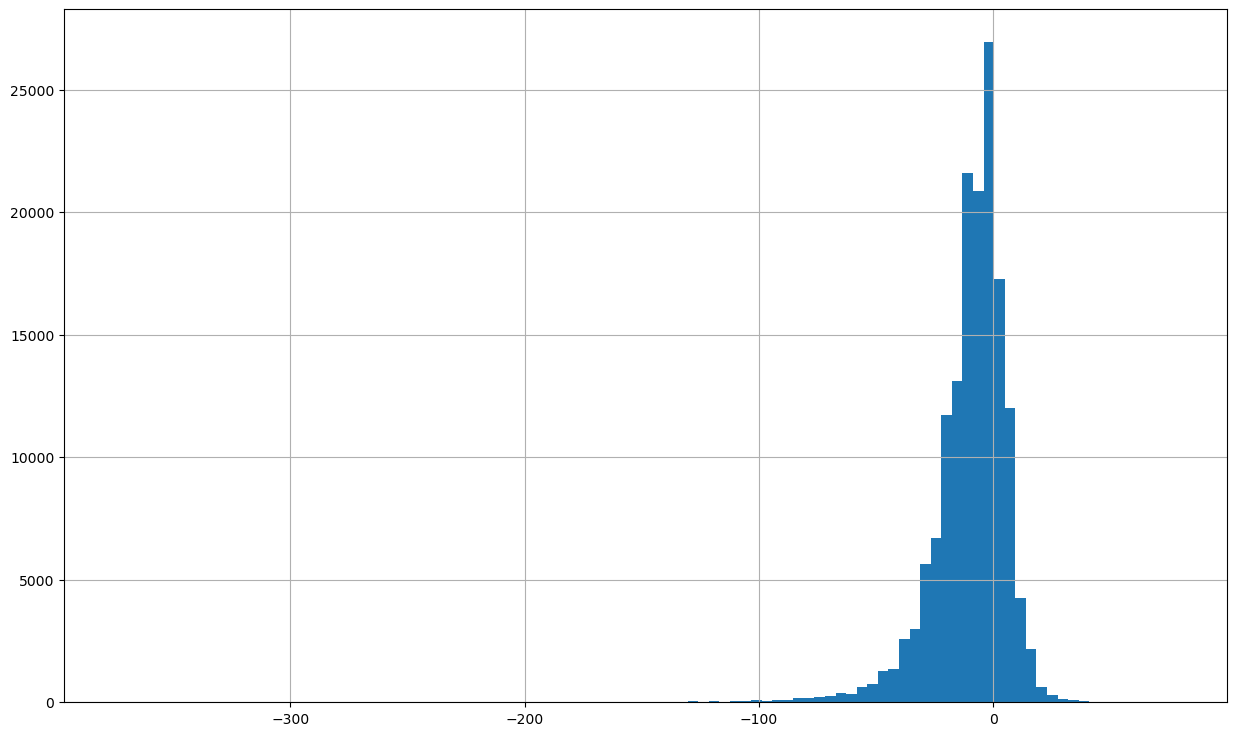

In [18]:
df["y_true"].hist(bins=100)

<AxesSubplot: >

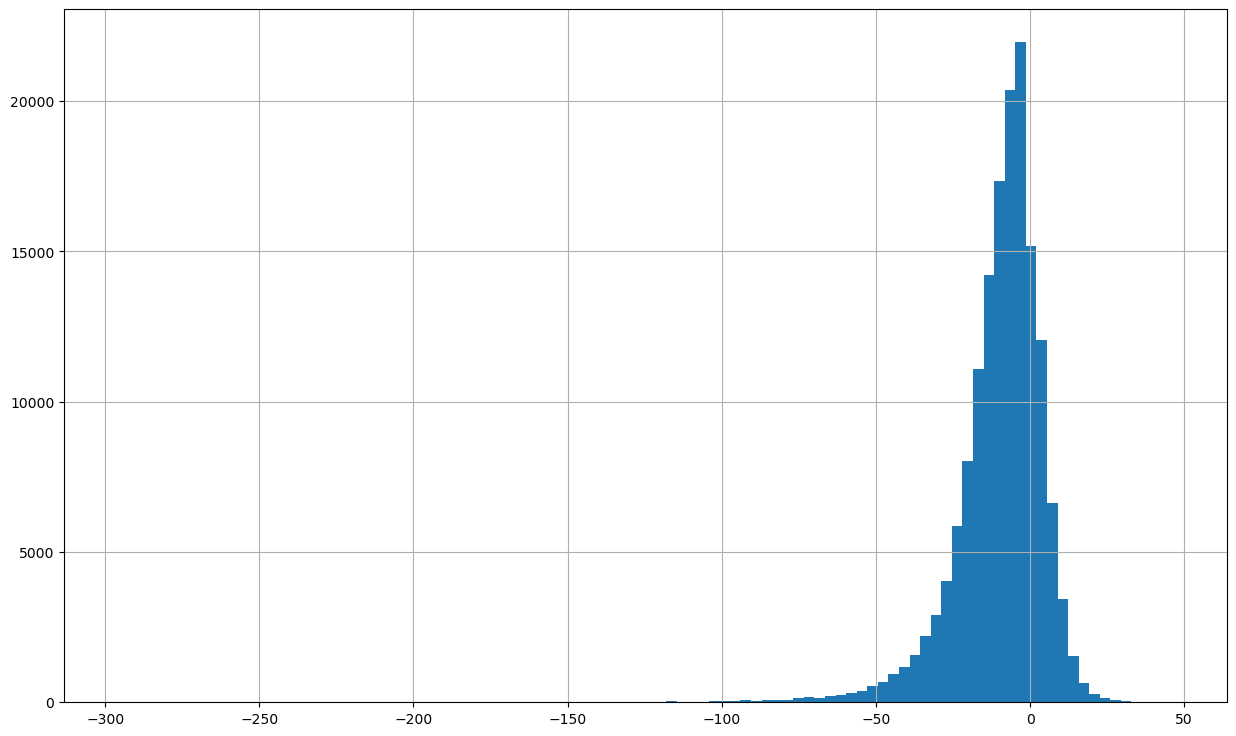

In [19]:
df["y_predict"].hist(bins=100)

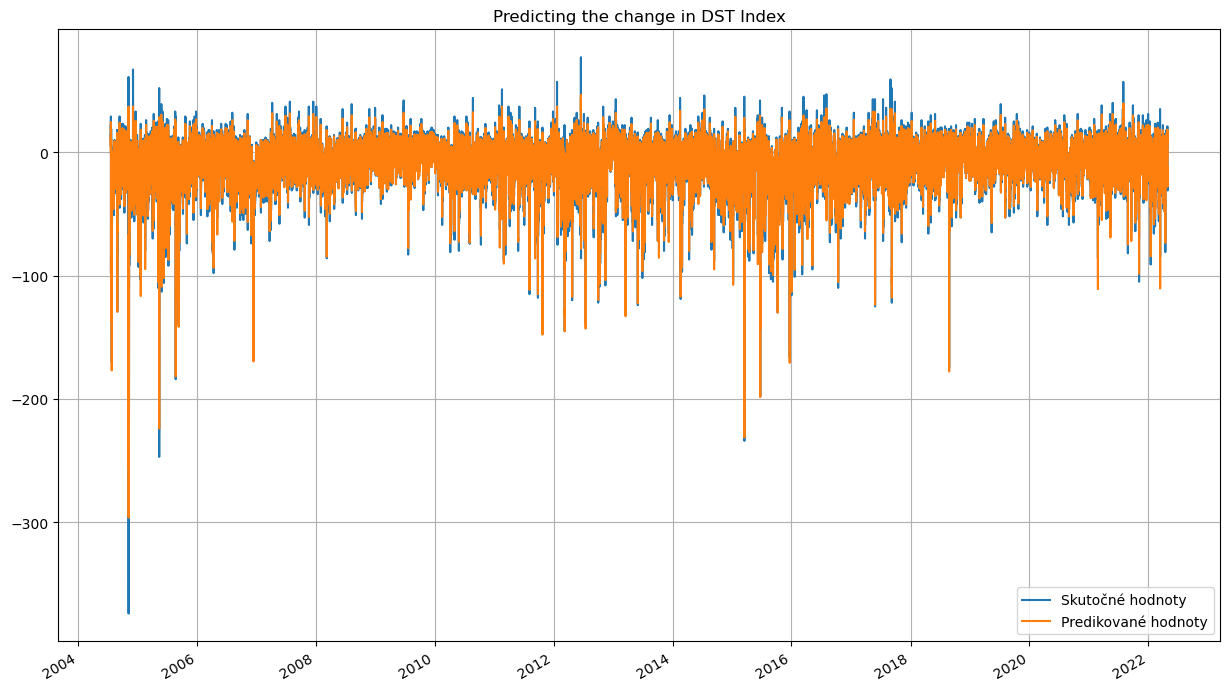

In [20]:
plt.figure()
plt.title('Predicting the change in DST Index')
plt.plot(df['time'],df['y_true'], label='Skutočné hodnoty')
plt.plot(df['time'],df['y_predict'], label='Predikované hodnoty')
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)

In [21]:
df.to_csv('predikcie_3h_dozadu.csv')

In [22]:
TN = cm[0,0] 
print(TN)
FP = cm[0,1]
print(FP)
FN = cm[1,0] 
print(FN)
TP = cm[1,1] 
print(TP)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("TPR={}".format(TPR))
# Specificity or true negative rate
TNR = TN/(TN+FP)
print("TNR={}".format(TNR))
# Precision or positive predictive value
PPV = TP/(TP+FP)
print("PPV={}".format(PPV))
# Negative predictive value
NPV = TN/(TN+FN)
print("NPV={}".format(NPV))
# Fall out or false positive rate
FPR = FP/(FP+TN)
print("FPR={}".format(FPR))
# False negative rate
FNR = FN/(TP+FN)
print("FNR={}".format(FNR))
# False discovery rate
FDR = FP/(TP+FP)
print("FDR={}".format(FDR))
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("ACC={}".format(ACC))
MCC = matthews_corrcoef(y_test2, y_pred2)
print("MCC={}".format(MCC))

123300
1336
5340
25280
TPR=0.8256041802743305
TNR=0.9892807856478064
PPV=0.94980462879471
NPV=0.9584888059701493
FPR=0.010719214352193588
FNR=0.1743958197256695
FDR=0.05019537120529005
ACC=0.9570000515277992
MCC=0.8603224190009597
